# Modeling

Predict Premium distribution

- Vehicle-related features: Area, Second_driver, Value_vehicle, N_doors, and Type_fuel. 
- Claim-related features: Cost_claims_year, N_claims_year, N_claims_history, and R_Claims_history. 
- Policy and customer-related characteristcs: contract_dura4on, Distribu4on_channel, yoe, Seniority, Policies_in_force, Max_products, and Payment.

In [282]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.gam.api as smg
from statsmodels.genmod.families.links import Identity, Log
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2

In [283]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Helper functions

In [284]:
def get_VIF(df):
    vif = pd.DataFrame(
        {
            'Variable': df.columns, 
            'VIF': [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        })
    
    return vif

In [285]:
def eval(model_results, df_pred, df_metrics, name, is_lognormal=False):

    if is_lognormal:
        df_pred[name] = np.exp(model_results.predict())
    else:
        df_pred[name] = model_results.predict()
    mae_glm_gamma = mean_absolute_error(df_pred['Premium'].to_numpy(), df_pred[name].to_numpy())
    rmse_glm_gamma = root_mean_squared_error(df_pred['Premium'].to_numpy(), df_pred[name].to_numpy())

    df_metrics.loc[-1] = [
        name, model_results.aic, model_results.deviance, model_results.null_deviance,
        mae_glm_gamma, rmse_glm_gamma
        ]
    df_metrics.index = df_metrics.index + 1 
    df_metrics = df_metrics.sort_index()

    print(f"{name} AIC: {model_results.aic}")
    print(f"{name} deviance: {model_results.deviance}")
    print(f"{name} null deviance: {model_results.null_deviance}")
    print(f"{name} MAE: {mae_glm_gamma:.2f}")
    print(f"{name} RMSE: {rmse_glm_gamma:.2f}")
    print(model_results.summary())

    return df_pred, df_metrics

In [286]:
def compare(m1, m2):
    # Extract log-likelihoods from both models
    LL_model1 = m1.llf  # Log-likelihood of model 1
    LL_model2 = m2.llf  # Log-likelihood of model 2

    # Calculate the test statistic (Likelihood Ratio Test)
    LR_stat = 2 * (LL_model2 - LL_model1)

    # Degrees of freedom difference (number of extra parameters in model2)
    df_diff = m2.df_model - m1.df_model

    # Compute p-value
    p_value = 1 - chi2.cdf(LR_stat, df_diff)

    # Print results
    print(f"Log-Likelihood Model 1: {LL_model1}")
    print(f"Log-Likelihood Model 2: {LL_model2}")
    print(f"Likelihood Ratio Test Statistic: {LR_stat}")
    print(f"Degrees of Freedom Difference: {df_diff}")
    print(f"P-value: {p_value}")

    # Interpretation
    if p_value < 0.05:
        print("Model 2 significantly improves fit over Model 1 (Reject Null Hypothesis).")
    else:
        print("No significant improvement in Model 2 over Model 1 (Fail to Reject Null).")

### Load data & prepare transformed data

In [287]:
# Load data.
data_path = './Dataset of an actual motor vehicle insurance portfolio/Motor v'\
    'ehicle insurance data.csv'

df = pd.read_csv(
    data_path, 
    delimiter=';', 
    parse_dates=[
        'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal',
        'Date_birth', 'Date_driving_licence', 'Date_lapse', 'Year_matriculation'
        ],
    dayfirst=True
    )

# Calculate Age.
df['Age'] = (df['Date_last_renewal'] - df['Date_birth']) // \
    pd.Timedelta('365 days')

# Calculate Year of Experience.
df['yoe'] = (df['Date_last_renewal'] - df['Date_driving_licence']) \
    // pd.Timedelta('365 days')

# Calculate contract duration
df['contract_duration'] = (df['Date_last_renewal'] - df['Date_start_contract'])\
    // pd.Timedelta('365 days') + 1

In [288]:
df.columns

Index(['ID', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal',
       'Date_birth', 'Date_driving_licence', 'Distribution_channel',
       'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
       'Lapse', 'Date_lapse', 'Payment', 'Premium', 'Cost_claims_year',
       'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk',
       'Area', 'Second_driver', 'Year_matriculation', 'Power',
       'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length',
       'Weight', 'Age', 'yoe', 'contract_duration'],
      dtype='object')

### Premium distribution

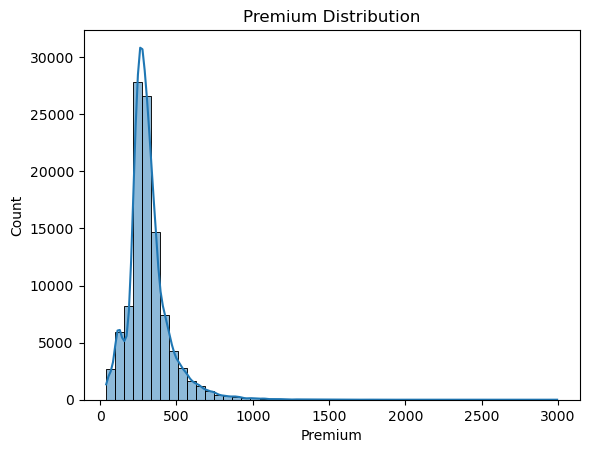

In [289]:
# Histogram to check distribution

sns.histplot(df['Premium'], bins=50, kde=True)
plt.title("Premium Distribution")
plt.show()

### Get selected dataframe.

In [290]:
# Get selected dataframe.

df_selected = df[
    ['Area', 'Second_driver', 'Value_vehicle', 'N_doors', 'Type_fuel',
     'Cost_claims_year', 'N_claims_year', 
     'contract_duration', 'Distribution_channel', 'yoe', 'Max_products', 'Payment',
     'Seniority', 'Policies_in_force', 'Premium'
     ]
    ]

# Fill type_fuel with mood value.
df_selected.fillna(
    {'Type_fuel': df_selected['Type_fuel'].mode()[0]}, inplace=True)

/var/folders/m9/v_7kl_w14lj9f1tgkvdq_cbm0000gn/T/ipykernel_11989/1707837896.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(


In [291]:
df_selected.head()

,Area,Second_driver,Value_vehicle,N_doors,Type_fuel,Cost_claims_year,N_claims_year,contract_duration,Distribution_channel,yoe,Max_products,Payment,Seniority,Policies_in_force,Premium
0,0,0,7068.000,0,P,0.000,0,1,0,39,1,0,4,1,222.520
1,0,0,7068.000,0,P,0.000,0,2,0,40,1,0,4,1,213.780
2,0,0,7068.000,0,P,0.000,0,3,0,41,1,0,4,2,214.840
3,0,0,7068.000,0,P,0.000,0,4,0,42,1,0,4,2,216.990
4,0,0,7068.000,0,P,0.000,0,1,0,41,1,1,4,2,213.700


In [292]:
# 12 numerical variables.
num_trans_cols = [
    'Value_vehicle_sqrt', 'Cost_claims_year_cbrt', 'N_claims_year_cbrt', 
    'contract_duration_cbrt', 'yoe', 'Max_products', 'Seniority_cbrt',
    'Policies_in_force_cbrt'
    ]
num_cols = ['Value_vehicle', 'Cost_claims_year', 'N_claims_year', 
            'contract_duration', 'yoe', 'Max_products', 'Seniority', 'Policies_in_force'
            ]

# 4 categorical variables.
cat_cols = ['Area', 'Second_driver', 'Type_fuel', 'Distribution_channel', 'Payment', 'N_doors']

### Transformation

- Value_vehicle --> np.sqrt
- Cost_claims_year --> np.cbrt
- N_claims_year --> np.cbrt
- N_claims_history --> np.cbrt
- R_Claims_history --> np.cbrt
- contract_duration --> np.cbrt
- yoe --> None
- Max_products --> None
- Seniority --> np.cbrt
- Policies_in_force --> np.cbrt

In [294]:
df_selected['Value_vehicle_sqrt'] = np.sqrt(df_selected['Value_vehicle'])
df_selected['Cost_claims_year_cbrt'] = np.cbrt(df_selected['Cost_claims_year'])
df_selected['N_claims_year_cbrt'] = np.sqrt(df_selected['N_claims_year'])
df_selected['contract_duration_cbrt'] = np.sqrt(df_selected['contract_duration'])
df_selected['Seniority_cbrt'] = np.sqrt(df_selected['Seniority'])
df_selected['Policies_in_force_cbrt'] = np.sqrt(df_selected['Policies_in_force'])

/var/folders/m9/v_7kl_w14lj9f1tgkvdq_cbm0000gn/T/ipykernel_11989/2821736077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Value_vehicle_sqrt'] = np.sqrt(df_selected['Value_vehicle'])
/var/folders/m9/v_7kl_w14lj9f1tgkvdq_cbm0000gn/T/ipykernel_11989/2821736077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Cost_claims_year_cbrt'] = np.cbrt(df_selected['Cost_claims_year'])
/var/folders/m9/v_7kl_w14lj9f1tgkvdq_cbm0000gn/T/ipykernel_11989/2821736077.py:3: SettingWithCopyWarni

### Scale numerical data

In [299]:
scaler = preprocessing.MinMaxScaler()
scaler_trans = preprocessing.MinMaxScaler()

df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_selected[num_cols]), 
    columns=num_cols
    )

df_num_trans_scaled = pd.DataFrame(
        scaler_trans.fit_transform(df_selected[num_trans_cols]),
        columns=num_trans_cols
        )

#### Check transformed distributions

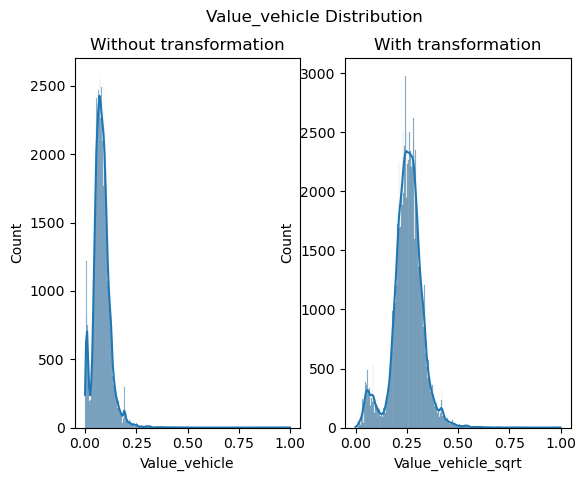

In [308]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Value_vehicle Distribution')

sns.histplot(ax=ax1, x=df_num_scaled['Value_vehicle'], kde=True)
sns.histplot(ax=ax2, x=df_num_trans_scaled['Value_vehicle_sqrt'], kde=True)

ax1.set_title('Without transformation')
ax2.set_title('With transformation')

plt.show()

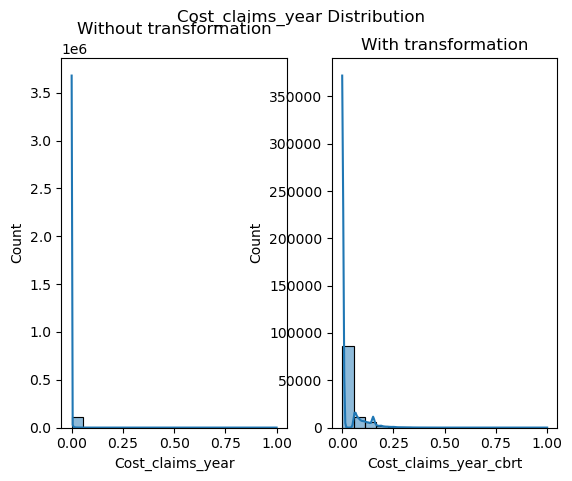

In [309]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Cost_claims_year Distribution')

sns.histplot(ax=ax1, x=df_num_scaled['Cost_claims_year'], kde=True)
sns.histplot(ax=ax2, x=df_num_trans_scaled['Cost_claims_year_cbrt'], kde=True)

ax1.set_title('Without transformation')
ax2.set_title('With transformation')

plt.show()

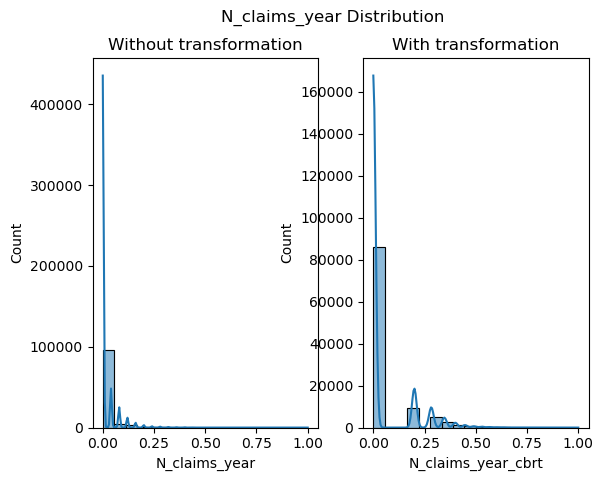

In [312]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('N_claims_year Distribution')

sns.histplot(ax=ax1, x=df_num_scaled['N_claims_year'], kde=True)
sns.histplot(ax=ax2, x=df_num_trans_scaled['N_claims_year_cbrt'], kde=True)

ax1.set_title('Without transformation')
ax2.set_title('With transformation')

plt.show()

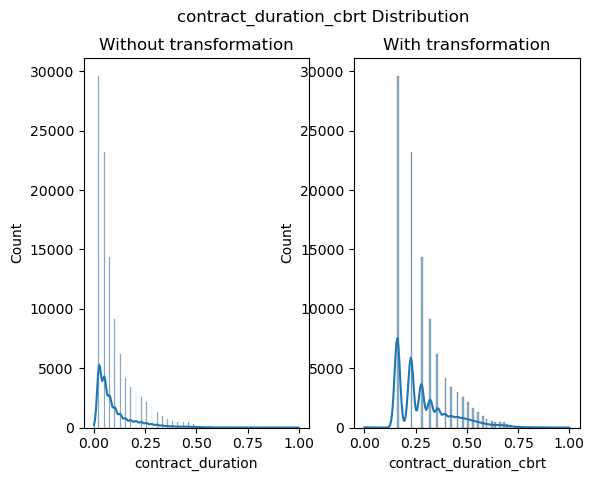

In [314]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('contract_duration_cbrt Distribution')

sns.histplot(ax=ax1, x=df_num_scaled['contract_duration'], kde=True)
sns.histplot(ax=ax2, x=df_num_trans_scaled['contract_duration_cbrt'], kde=True)

ax1.set_title('Without transformation')
ax2.set_title('With transformation')

plt.show()


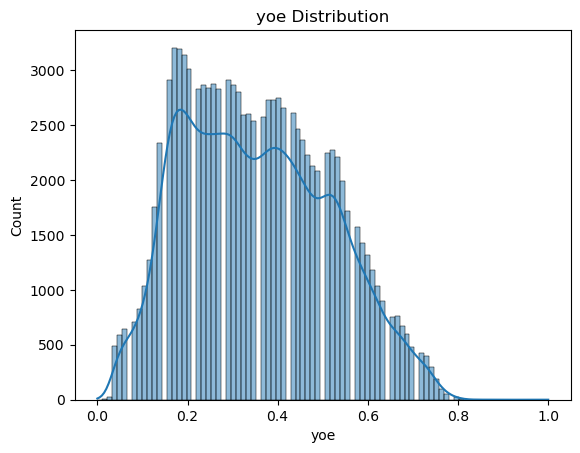

In [315]:
sns.histplot(df_num_scaled['yoe'], kde=True)
plt.title("yoe Distribution")
plt.show()

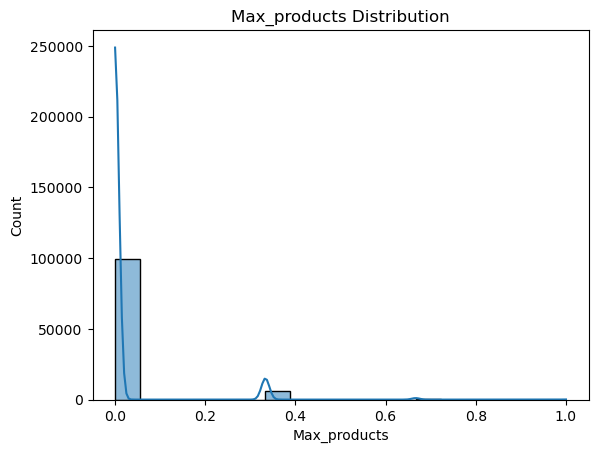

In [316]:
sns.histplot(df_num_scaled['Max_products'], kde=True)
plt.title("Max_products Distribution")
plt.show()

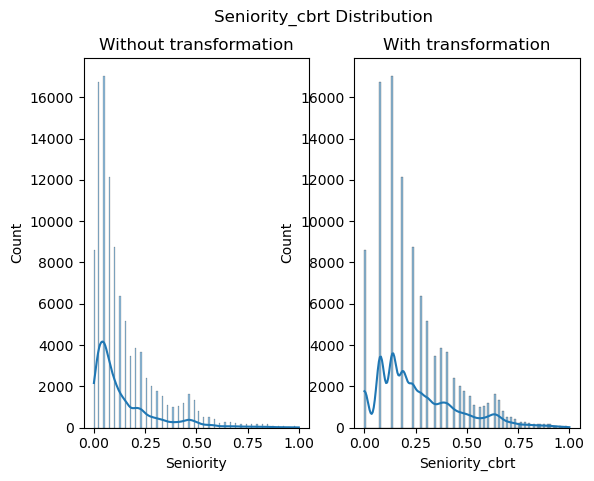

In [317]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Seniority_cbrt Distribution')

sns.histplot(ax=ax1, x=df_num_scaled['Seniority'], kde=True)
sns.histplot(ax=ax2, x=df_num_trans_scaled['Seniority_cbrt'], kde=True)

ax1.set_title('Without transformation')
ax2.set_title('With transformation')

plt.show()

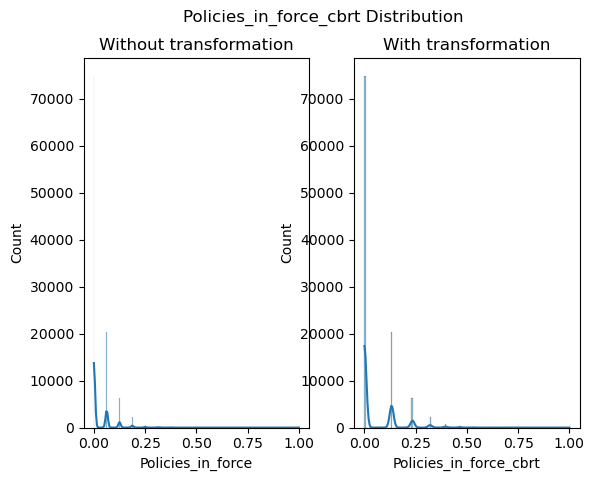

In [318]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Policies_in_force_cbrt Distribution')

sns.histplot(ax=ax1, x=df_num_scaled['Policies_in_force'], kde=True)
sns.histplot(ax=ax2, x=df_num_trans_scaled['Policies_in_force_cbrt'], kde=True)

ax1.set_title('Without transformation')
ax2.set_title('With transformation')

plt.show()

### Covert categorical data

In [296]:
df_cat_dum = pd.get_dummies(
    df_selected[cat_cols], drop_first=True, dtype=int)

In [297]:
df_cat_dum.shape

(105555, 6)

### Combine predictors

In [223]:
X = pd.concat([df_num_scaled, df_cat_dum], axis=1)
X_trans = pd.concat([df_num_trans_scaled, df_cat_dum], axis=1)

y = df_selected['Premium']

## Modelling

- Gamma Distribution (common for positive continuous data)
- Log-Normal Distribution (if the log of premium follows a normal distribution)

### GLM

In [224]:
df_pred = pd.DataFrame(y)
df_metrics = pd.DataFrame(columns=['name', 'AIC', 'Deviance', 'Null_deviance', 'MAE', 'RMSE'])

In [11]:
df_pred

,Premium
0,222.52
1,213.78
2,214.84
3,216.99
4,213.70
...,...
105550,263.79
105551,418.97
105552,571.91
105553,339.66


In [225]:
df_metrics

,name,AIC,Deviance,Null_deviance,MAE,RMSE


#### Non-transformation - all variables

###### Log Gamma

In [226]:
# Add intercept
X = sm.add_constant(X)

# Fit a GLM model using Gamma distribution with log link
glm_gamma_model_all= sm.GLM(y, X, family=sm.families.Gamma(link=Log()))
glm_gamma_result_all = glm_gamma_model_all.fit()

# Eval model.
df_pred, df_metrics = eval(
    glm_gamma_result_all, df_pred, df_metrics, 'glm-gamma-no_trans-all', 
    is_lognormal=False)

glm-gamma-no_trans-all AIC: 1269148.854159901
glm-gamma-no_trans-all deviance: 12072.709929328197
glm-gamma-no_trans-all null deviance: 19339.8220824751
glm-gamma-no_trans-all MAE: 79.63
glm-gamma-no_trans-all RMSE: 128.24
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                            GLM   Df Residuals:                   105540
Model Family:                   Gamma   Df Model:                           14
Link Function:                    Log   Scale:                         0.12665
Method:                          IRLS   Log-Likelihood:            -6.3456e+05
Date:                Sun, 23 Mar 2025   Deviance:                       12073.
Time:                        00:46:19   Pearson chi2:                 1.34e+04
No. Iterations:                    42   Pseudo R-squ. (CS):             0.4194
Covariance Type:            nonrobust                             

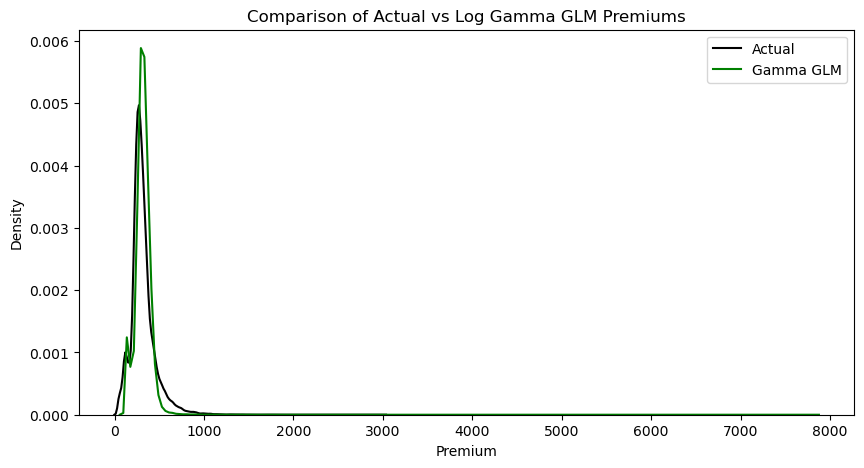

In [227]:
# Plot actual vs. predicted premiums
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['glm-gamma-no_trans-all'], label="Gamma GLM", color='green')
# sns.kdeplot(df_pred['glm_lognorm_pred'], label="Log-Normal GLM", color='blue')

plt.legend()
plt.title("Comparison of Actual vs Log Gamma GLM Premiums")
plt.show()

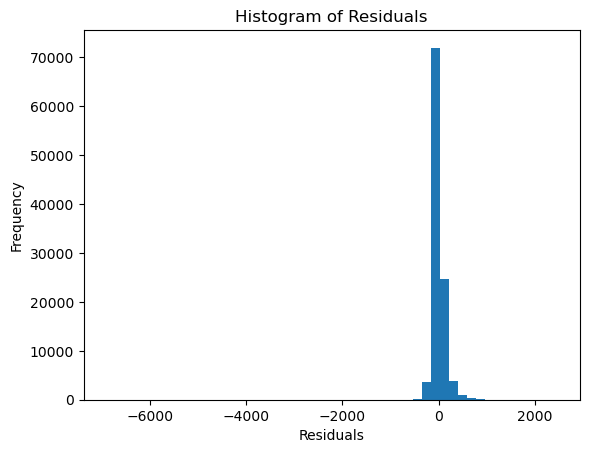

In [228]:
residuals = glm_gamma_result_all.resid_response
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

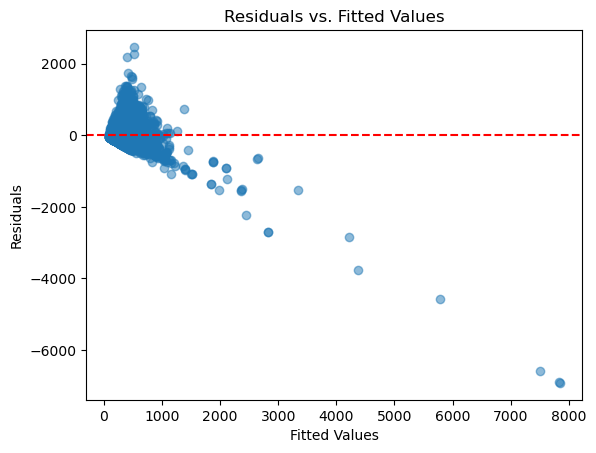

In [229]:
plt.scatter(
    glm_gamma_result_all.fittedvalues, 
    glm_gamma_result_all.resid_response, 
    alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

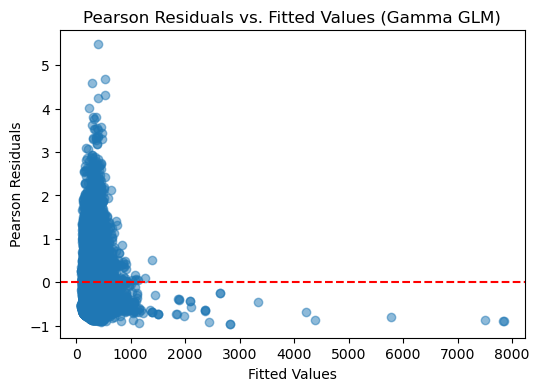

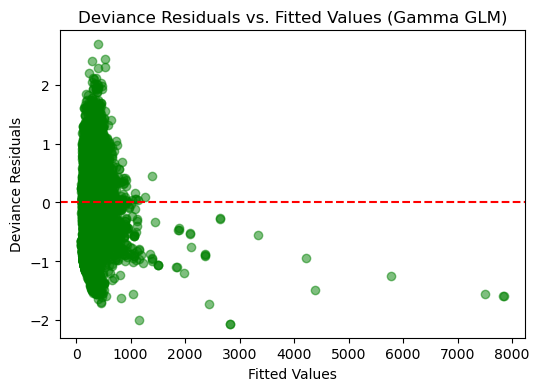

In [230]:
# 3. Extract fitted values and desired residuals
fitted_vals = glm_gamma_result_all.fittedvalues

# Using Pearson residuals:
pearson_resids = glm_gamma_result_all.resid_pearson
# Using deviance residuals:
deviance_resids = glm_gamma_result_all.resid_deviance

# 4. Plot Pearson Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, pearson_resids, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

# 5. (Optional) Plot Deviance Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, deviance_resids, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Deviance Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

###### Log Normal

In [231]:
# Fit GLM using log-normal (Gaussian on log-transformed y)
glm_lognorm_model_all = sm.GLM(
    np.log(y), X, family=sm.families.Gaussian(link=Identity()))
glm_lognorm_result_all = glm_lognorm_model_all.fit()

# Eval model.
df_pred, df_metrics = eval(
    glm_lognorm_result_all, df_pred, df_metrics, 'glm-ln-no_trans-all', 
    is_lognormal=True)

glm-ln-no_trans-all AIC: 72580.39910660751
glm-ln-no_trans-all deviance: 12288.676955302059
glm-ln-no_trans-all null deviance: 20789.15280508835
glm-ln-no_trans-all MAE: 77.46
glm-ln-no_trans-all RMSE: 122.45
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                            GLM   Df Residuals:                   105540
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                         0.11644
Method:                          IRLS   Log-Likelihood:                -36275.
Date:                Sun, 23 Mar 2025   Deviance:                       12289.
Time:                        00:46:32   Pearson chi2:                 1.23e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4992
Covariance Type:            nonrobust                                         
 

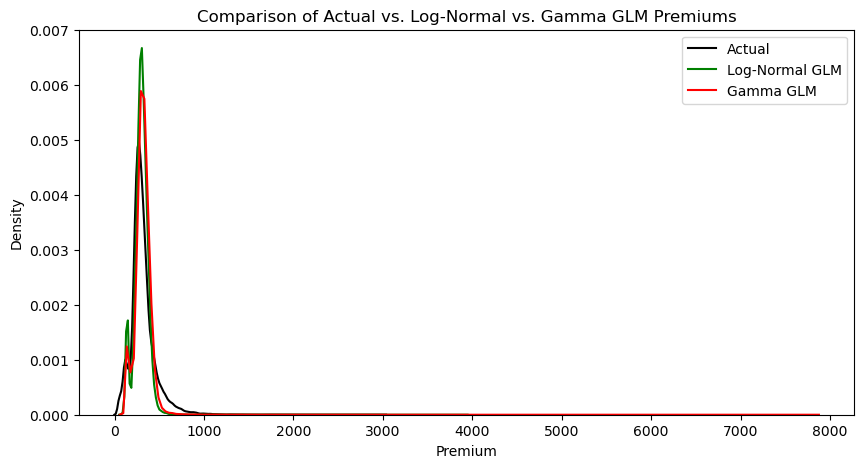

In [232]:
# Plot actual vs. predicted premiums
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['glm-ln-no_trans-all'], label="Log-Normal GLM", color='green')
sns.kdeplot(df_pred['glm-gamma-no_trans-all'], label="Gamma GLM", color='red')

plt.legend()
plt.title("Comparison of Actual vs. Log-Normal vs. Gamma GLM Premiums")
plt.show()

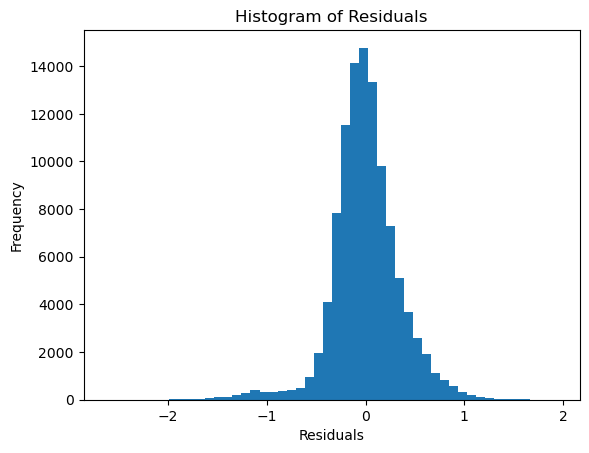

In [233]:
residuals = glm_lognorm_result_all.resid_response
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

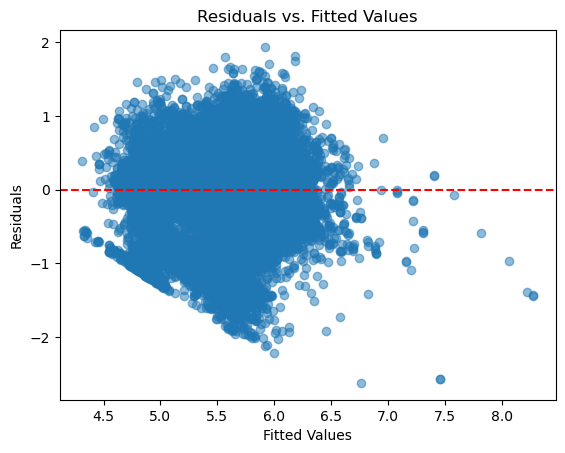

In [234]:
plt.scatter(
    glm_lognorm_result_all.fittedvalues,
    glm_lognorm_result_all.resid_response, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

###### Compare

In [235]:
compare(m1=glm_gamma_result_all, m2=glm_lognorm_result_all)

Log-Likelihood Model 1: -634559.4270799505
Log-Likelihood Model 2: -36275.199553303755
Likelihood Ratio Test Statistic: 1196568.4550532934
Degrees of Freedom Difference: 0
P-value: nan
No significant improvement in Model 2 over Model 1 (Fail to Reject Null).


In [238]:
df_metrics

,name,AIC,Deviance,Null_deviance,MAE,RMSE
0,glm-ln-no_trans-all,72580.399,12288.677,20789.153,77.456,122.453
1,glm-gamma-no_trans-all,1269148.854,12072.710,19339.822,79.628,128.237


#### Gamma - Transformation

In [276]:
# Fit a GLM model using Gamma distribution with log link
glm_gamma_model_trans_all= sm.GLM(
    y, 
    X_trans,
    family=sm.families.Gamma(link=Log()))
glm_gamma_result_trans_all = glm_gamma_model_trans_all.fit()

# Eval model.
df_pred, df_metrics = eval(
    glm_gamma_result_trans_all, df_pred, df_metrics, 
    'glm-gamma-trans-all', 
    is_lognormal=False)

glm-gamma-trans-all AIC: 1522807.1808458942
glm-gamma-trans-all deviance: 91737.38443798362
glm-gamma-trans-all null deviance: 19339.8220824751
glm-gamma-trans-all MAE: 600.33
glm-gamma-trans-all RMSE: 7864.66
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                            GLM   Df Residuals:                   105541
Model Family:                   Gamma   Df Model:                           13
Link Function:                    Log   Scale:                          1.5918
Method:                          IRLS   Log-Likelihood:            -7.6139e+05
Date:                Sun, 23 Mar 2025   Deviance:                       91737.
Time:                        13:54:21   Pearson chi2:                 1.68e+05
No. Iterations:                    88   Pseudo R-squ. (CS):            -0.5386
Covariance Type:            nonrobust                                         


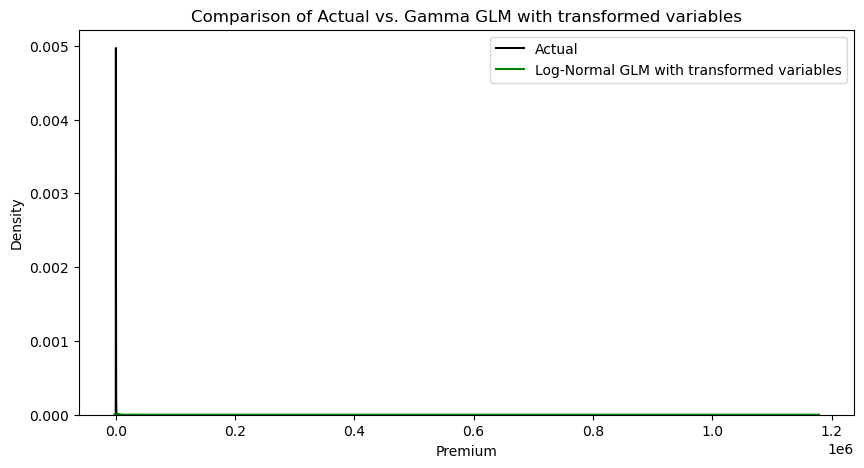

In [277]:
# Plot actual vs. predicted premiums
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['glm-gamma-trans-all'], label="Log-Normal GLM with transformed variables", color='green')

plt.legend()
plt.title("Comparison of Actual vs. Gamma GLM with transformed variables")
plt.show()

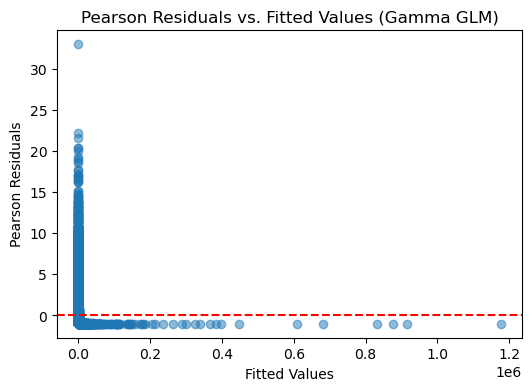

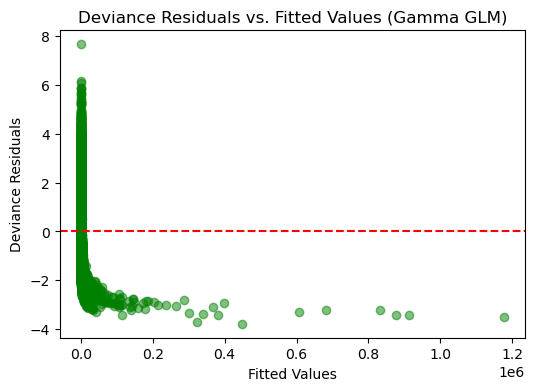

In [240]:
# 3. Extract fitted values and desired residuals
fitted_vals = glm_gamma_result_trans_all.fittedvalues

# Using Pearson residuals:
pearson_resids = glm_gamma_result_trans_all.resid_pearson
# Using deviance residuals:
deviance_resids = glm_gamma_result_trans_all.resid_deviance

# 4. Plot Pearson Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, pearson_resids, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

# 5. (Optional) Plot Deviance Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, deviance_resids, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Deviance Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

In [241]:
compare(m1=glm_gamma_result_all, m2=glm_gamma_result_trans_all)

Log-Likelihood Model 1: -634559.4270799505
Log-Likelihood Model 2: -761389.5904229471
Likelihood Ratio Test Statistic: -253660.32668599323
Degrees of Freedom Difference: -1
P-value: nan
No significant improvement in Model 2 over Model 1 (Fail to Reject Null).


In [242]:
df_metrics

,name,AIC,Deviance,Null_deviance,MAE,RMSE
0,glm-gamma-trans-all,1522807.181,91737.384,19339.822,600.327,7864.663
1,glm-ln-no_trans-all,72580.399,12288.677,20789.153,77.456,122.453
2,glm-gamma-no_trans-all,1269148.854,12072.710,19339.822,79.628,128.237


### Gamma Interaction Terms

In [264]:
X = pd.concat([df_num_scaled, df_cat_dum, df_selected['Premium']], axis=1)

In [57]:
formula = "Premium ~ Value_vehicle + Cost_claims_year + N_claims_year + contract_duration + yoe + Max_products + Seniority + Policies_in_force + \
Area + Second_driver + Type_fuel_P + Distribution_channel + Payment + N_doors + Type_fuel_P + \
Value_vehicle:Area + Cost_claims_year:Area + N_claims_year:Area + contract_duration:Area + yoe:Area + Max_products:Area + Seniority:Area + Policies_in_force:Area + \
Second_driver:Area + Type_fuel_P:Area + Distribution_channel:Area + Payment:Area + N_doors:Area + Type_fuel_P:Area +\
Value_vehicle:Second_driver + Cost_claims_year:Second_driver + N_claims_year:Second_driver + contract_duration:Second_driver + yoe:Second_driver + Max_products:Second_driver + Seniority:Second_driver + Policies_in_force:Second_driver + \
Type_fuel_P:Second_driver + Distribution_channel:Second_driver + Payment:Second_driver + N_doors:Second_driver + Type_fuel_P:Second_driver +\
Value_vehicle:Distribution_channel + Cost_claims_year:Distribution_channel + N_claims_year:Distribution_channel + contract_duration:Distribution_channel + yoe:Distribution_channel + Max_products:Distribution_channel + Seniority:Distribution_channel + Policies_in_force:Distribution_channel + \
Type_fuel_P:Distribution_channel + Payment:Distribution_channel + N_doors:Distribution_channel + \
Value_vehicle:Payment + Cost_claims_year:Payment + N_claims_year:Payment + contract_duration:Payment + yoe:Payment + Max_products:Payment + Seniority:Payment + Policies_in_force:Payment + \
N_doors:Payment + Type_fuel_P:Payment"
formula

'Premium ~ Value_vehicle + Cost_claims_year + N_claims_year + contract_duration + yoe + Max_products + Seniority + Policies_in_force + Area + Second_driver + Type_fuel_P + Distribution_channel + Payment + N_doors + Type_fuel_P + Value_vehicle:Area + Cost_claims_year:Area + N_claims_year:Area + contract_duration:Area + yoe:Area + Max_products:Area + Seniority:Area + Policies_in_force:Area + Second_driver:Area + Type_fuel_P:Area + Distribution_channel:Area + Payment:Area + N_doors:Area + Type_fuel_P:Area +Value_vehicle:Second_driver + Cost_claims_year:Second_driver + N_claims_year:Second_driver + contract_duration:Second_driver + yoe:Second_driver + Max_products:Second_driver + Seniority:Second_driver + Policies_in_force:Second_driver + Type_fuel_P:Second_driver + Distribution_channel:Second_driver + Payment:Second_driver + N_doors:Second_driver + Type_fuel_P:Second_driver +Value_vehicle:Distribution_channel + Cost_claims_year:Distribution_channel + N_claims_year:Distribution_channel + c

In [60]:
# Define the GLM model with a Gamma family (or change based on distribution)
glm_gamma_inter_all = smf.glm(
    formula=formula, data=X, family=sm.families.Gamma(link=Log()))

# Fit the model
glm_gamma_inter_result_all = glm_gamma_inter_all.fit()

# Print summary of results
# print(glm_gamma_inter_result_all.summary())
df_pred, df_metrics = eval(glm_gamma_inter_result_all, df_pred, df_metrics, 
     'glm_gamma_inter_result_all')

glm_gamma_inter_result_all AIC: 1265697.1765506694
glm_gamma_inter_result_all deviance: 11664.209348562727
glm_gamma_inter_result_all null deviance: 19339.8220824751
glm_gamma_inter_result_all MAE: 78.33
glm_gamma_inter_result_all RMSE: 129.35
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                            GLM   Df Residuals:                   105494
Model Family:                   Gamma   Df Model:                           60
Link Function:                    Log   Scale:                         0.12392
Method:                          IRLS   Log-Likelihood:            -6.3279e+05
Date:                Sat, 22 Mar 2025   Deviance:                       11664.
Time:                        22:07:12   Pearson chi2:                 1.31e+04
No. Iterations:                    67   Pseudo R-squ. (CS):             0.4439
Covariance Type:            nonrobust        

In [67]:
compare(m1=glm_gamma_result_all, m2=glm_gamma_inter_result_all)

Log-Likelihood Model 1: -634559.4270799505
Log-Likelihood Model 2: -632803.6538380254
Likelihood Ratio Test Statistic: 3511.5464838501066
Degrees of Freedom Difference: 19
P-value: 0.0
Model 2 significantly improves fit over Model 1 (Reject Null Hypothesis).


###### Gamma - remove non-significant

In [265]:
formula = "Premium ~ Value_vehicle + Cost_claims_year + N_claims_year + yoe + Seniority + Policies_in_force + \
Second_driver + Payment + N_doors + \
Value_vehicle:Area +contract_duration:Area + \
Distribution_channel:Area + Payment:Area + N_doors:Area + \
Value_vehicle:Second_driver + N_claims_year:Second_driver + contract_duration:Second_driver + yoe:Second_driver + Seniority:Second_driver + Policies_in_force:Second_driver + \
Distribution_channel:Second_driver + N_doors:Second_driver + \
Value_vehicle:Distribution_channel + contract_duration:Distribution_channel +  Policies_in_force:Distribution_channel + \
 N_doors:Distribution_channel + \
Value_vehicle:Payment + Cost_claims_year:Payment + N_claims_year:Payment + yoe:Payment + Policies_in_force:Payment + \
N_doors:Payment + Type_fuel_P:Payment"

In [266]:
# Define the GLM model with a Gamma family (or change based on distribution)
glm_gamma_inter_sig = smf.glm(
    formula=formula, data=X, family=sm.families.Gamma(link=Log()))

# Fit the model
glm_gamma_inter_result_sig = glm_gamma_inter_sig.fit()

# Print summary of results
# print(glm_gamma_inter_result_all.summary())
df_pred, df_metrics = eval(glm_gamma_inter_result_sig, df_pred, df_metrics, 
     'glm_gamma_inter_result_sig')

glm_gamma_inter_result_sig AIC: 1265675.3076760508
glm_gamma_inter_result_sig deviance: 11668.112170634893
glm_gamma_inter_result_sig null deviance: 19339.8220824751
glm_gamma_inter_result_sig MAE: 78.34
glm_gamma_inter_result_sig RMSE: 129.87
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                            GLM   Df Residuals:                   105521
Model Family:                   Gamma   Df Model:                           33
Link Function:                    Log   Scale:                         0.12393
Method:                          IRLS   Log-Likelihood:            -6.3280e+05
Date:                Sun, 23 Mar 2025   Deviance:                       11668.
Time:                        08:56:08   Pearson chi2:                 1.31e+04
No. Iterations:                    49   Pseudo R-squ. (CS):             0.4437
Covariance Type:            nonrobust        

In [66]:
compare(m1=glm_gamma_inter_result_all, m2=glm_gamma_inter_result_sig)

Log-Likelihood Model 1: -632803.6538380254
Log-Likelihood Model 2: -632803.6538380254
Likelihood Ratio Test Statistic: 0.0
Degrees of Freedom Difference: 0
P-value: nan
No significant improvement in Model 2 over Model 1 (Fail to Reject Null).


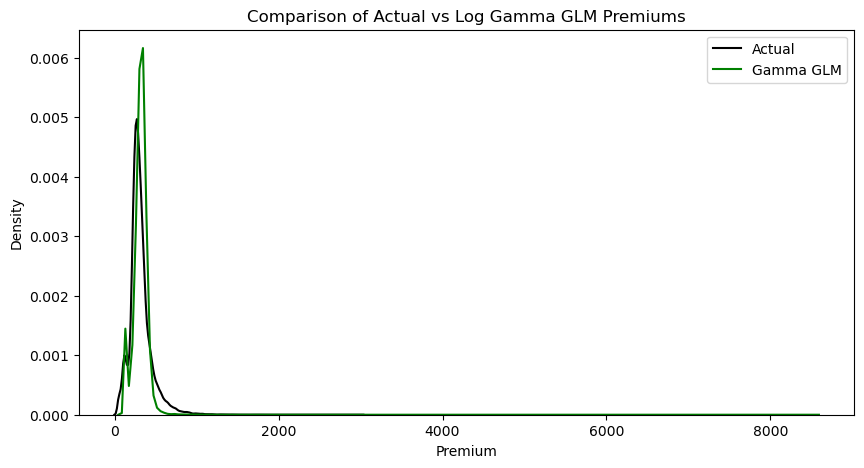

In [68]:
# Plot actual vs. predicted premiums
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['glm_gamma_inter_result_sig'], label="Gamma GLM", color='green')

plt.legend()
plt.title("Comparison of Actual vs Log Gamma GLM Premiums")
plt.show()

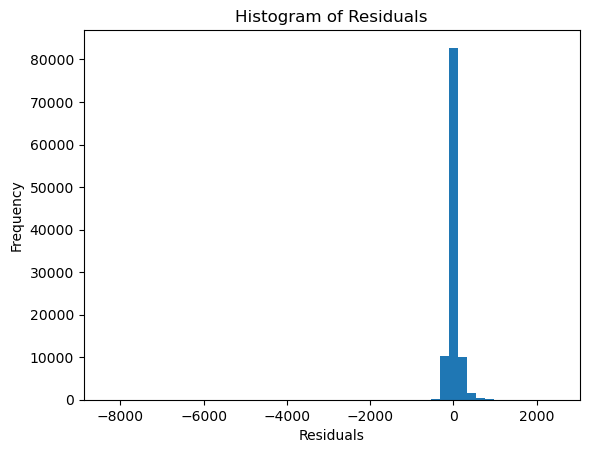

In [70]:
residuals = glm_gamma_inter_result_sig.resid_response
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

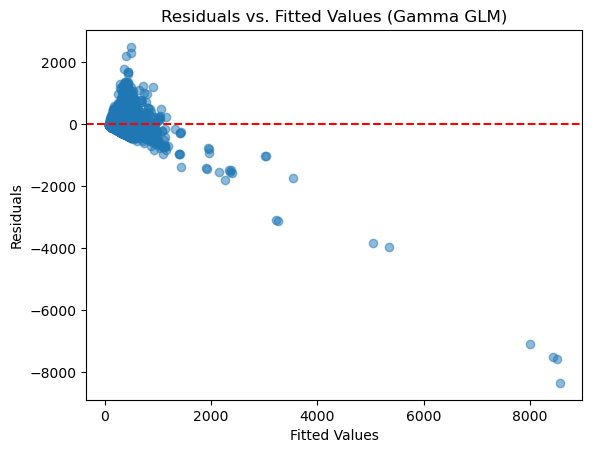

In [275]:
plt.scatter(
    glm_gamma_inter_result_sig.fittedvalues, 
    glm_gamma_inter_result_sig.resid_response, 
    alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

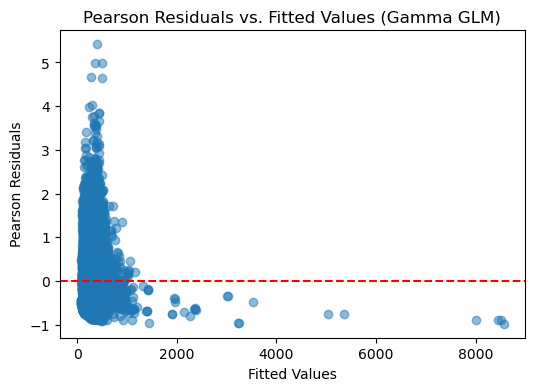

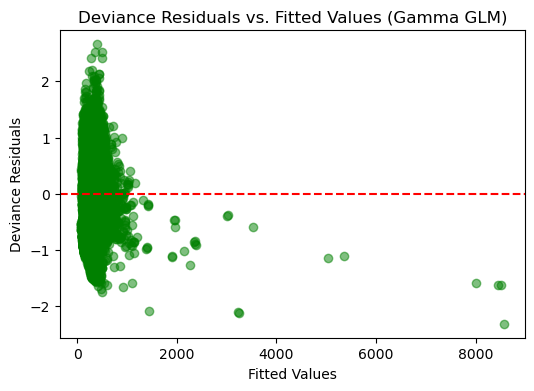

In [72]:
# 3. Extract fitted values and desired residuals
fitted_vals = glm_gamma_inter_result_sig.fittedvalues

# Using Pearson residuals:
pearson_resids = glm_gamma_inter_result_sig.resid_pearson
# Using deviance residuals:
deviance_resids = glm_gamma_inter_result_sig.resid_deviance

# 4. Plot Pearson Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, pearson_resids, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

# 5. (Optional) Plot Deviance Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, deviance_resids, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Deviance Residuals vs. Fitted Values (Gamma GLM)")
plt.show()

### GAM

In [ ]:
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.smooth_basis import BSplines

###### No trans

In [246]:
X = pd.concat([df_num_scaled, df_cat_dum], axis=1)
y = df_selected['Premium']

In [ ]:
sm_cols = [
    'Value_vehicle', 'Cost_claims_year', 'N_claims_year', 
    ]

In [248]:
# Select numerical variables to apply smoothing splines
spline_columns = sm_cols

# Define basis splines for numerical predictors
X_spline = X[spline_columns]
splines = BSplines(X_spline, df=[4] * len(sm_cols), degree=[3] * len(sm_cols)) 

# Fit GAMGam model
gam_gamma_all = GLMGam(
    y, sm.add_constant(X),
    smoother=splines,
    alpha=0.3,
    family=sm.families.Gamma(link=Log())  # Gamma family with log-link
)

gam_gamma_result_all = gam_gamma_all.fit()

df_pred, df_metrics = eval(gam_gamma_result_all, df_pred, df_metrics, 
     'gam_gamma_all')

gam_gamma_all AIC: 1267643.0722469469
gam_gamma_all deviance: 11906.820090755287
gam_gamma_all null deviance: 19339.8220824751
gam_gamma_all MAE: 78.69
gam_gamma_all RMSE: 118.99
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                         GLMGam   Df Residuals:                105538.41
Model Family:                   Gamma   Df Model:                        15.59
Link Function:                    Log   Scale:                         0.12472
Method:                         PIRLS   Log-Likelihood:            -6.3380e+05
Date:                Sun, 23 Mar 2025   Deviance:                       11907.
Time:                        08:37:17   Pearson chi2:                 1.32e+04
No. Iterations:                    32   Pseudo R-squ. (CS):             0.4314
Covariance Type:            nonrobust                                         
                           coef

In [249]:
compare(glm_gamma_inter_result_sig, gam_gamma_result_all)

Log-Likelihood Model 1: -632803.6538380254
Log-Likelihood Model 2: -633804.9479038314
Likelihood Ratio Test Statistic: -2002.588131611934
Degrees of Freedom Difference: -17.41178035795317
P-value: nan
No significant improvement in Model 2 over Model 1 (Fail to Reject Null).


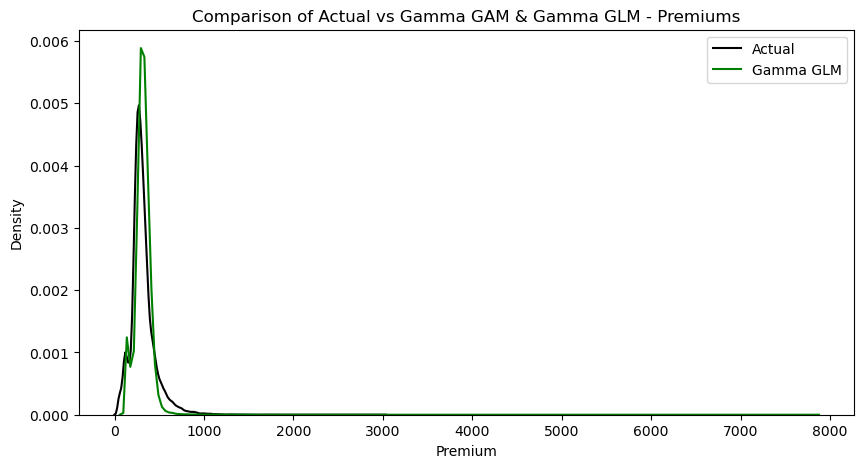

In [321]:
# Plot actual vs. predicted premiums
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['glm-gamma-no_trans-all'], label="Gamma GLM", color='green')

plt.legend()
plt.title("Comparison of Actual vs Gamma GAM & Gamma GLM - Premiums")
plt.show()

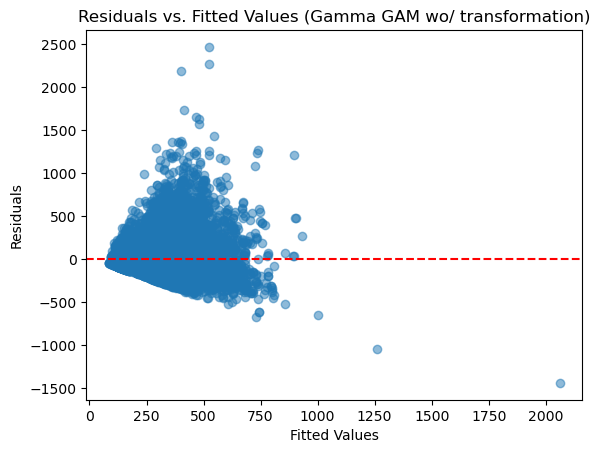

In [272]:
plt.scatter(
    gam_gamma_result_all.fittedvalues, 
    gam_gamma_result_all.resid_response, 
    alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values (Gamma GAM wo/ transformation)")
plt.show()

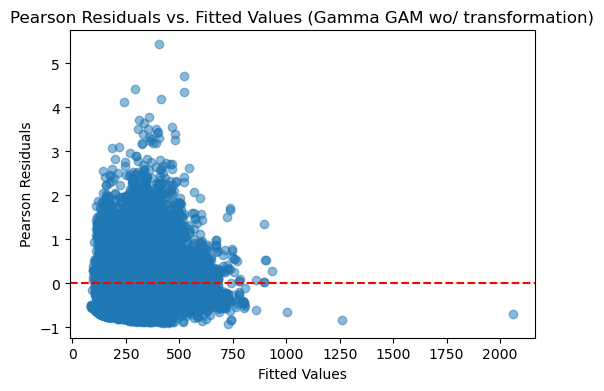

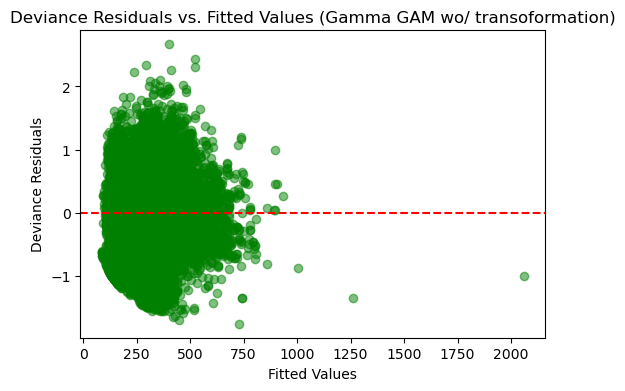

In [273]:
# 3. Extract fitted values and desired residuals
fitted_vals = gam_gamma_result_all.fittedvalues

# Using Pearson residuals:
pearson_resids = gam_gamma_result_all.resid_pearson
# Using deviance residuals:
deviance_resids = gam_gamma_result_all.resid_deviance

# 4. Plot Pearson Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, pearson_resids, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs. Fitted Values (Gamma GAM wo/ transformation)")
plt.show()

# 5. (Optional) Plot Deviance Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, deviance_resids, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Deviance Residuals vs. Fitted Values (Gamma GAM wo/ transoformation)")
plt.show()

###### GAM trans

In [255]:
X_trans = pd.concat([df_num_trans_scaled, df_cat_dum], axis=1)
y = df_selected['Premium']

In [165]:
num_trans_cols

['Value_vehicle_sqrt',
 'Cost_claims_year_cbrt',
 'N_claims_year_cbrt',
 'contract_duration_cbrt',
 'yoe',
 'Max_products',
 'Seniority_cbrt',
 'Policies_in_force_cbrt']

In [ ]:
sm_cols = [
    'Value_vehicle_sqrt', 'Cost_claims_year_cbrt', 'N_claims_year_cbrt', 
    'Policies_in_force_cbrt']


In [257]:
# Select numerical variables to apply smoothing splines
spline_columns = sm_cols

# Define basis splines for numerical predictors
X_spline = X_trans[spline_columns]
splines = BSplines(X_spline, df=[3] * len(sm_cols), degree=[2] * len(sm_cols))  # 6 splines for each variable

# Fit GAMGam model
gam_gamma_trains_all = GLMGam(
    y, sm.add_constant(X_trans),
    smoother=splines,
    alpha=0.3,
    family=sm.families.Gamma(link=Log())  # Gamma family with log-link
)

gam_gamma_result_trans_all = gam_gamma_trains_all.fit()

df_pred, df_metrics = eval(gam_gamma_result_trans_all, df_pred, df_metrics, 
     'gam_gamma_trans_all')

gam_gamma_trans_all AIC: 1265719.3401619853
gam_gamma_trans_all deviance: 11694.875716010894
gam_gamma_trans_all null deviance: 19339.8220824751
gam_gamma_trans_all MAE: 77.87
gam_gamma_trans_all RMSE: 118.12
                 Generalized Linear Model Regression Results                  
Dep. Variable:                Premium   No. Observations:               105555
Model:                         GLMGam   Df Residuals:                105537.00
Model Family:                   Gamma   Df Model:                        17.00
Link Function:                    Log   Scale:                         0.12259
Method:                         PIRLS   Log-Likelihood:            -6.3284e+05
Date:                Sun, 23 Mar 2025   Deviance:                       11695.
Time:                        08:51:37   Pearson chi2:                 1.29e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4461
Covariance Type:            nonrobust                                         
 

In [258]:
compare(m1=gam_gamma_result_all, m2=gam_gamma_result_trans_all)

Log-Likelihood Model 1: -633804.9479038314
Log-Likelihood Model 2: -632841.6702616786
Likelihood Ratio Test Statistic: 1926.5552843054757
Degrees of Freedom Difference: 1.4115996719703077
P-value: 0.0
Model 2 significantly improves fit over Model 1 (Reject Null Hypothesis).


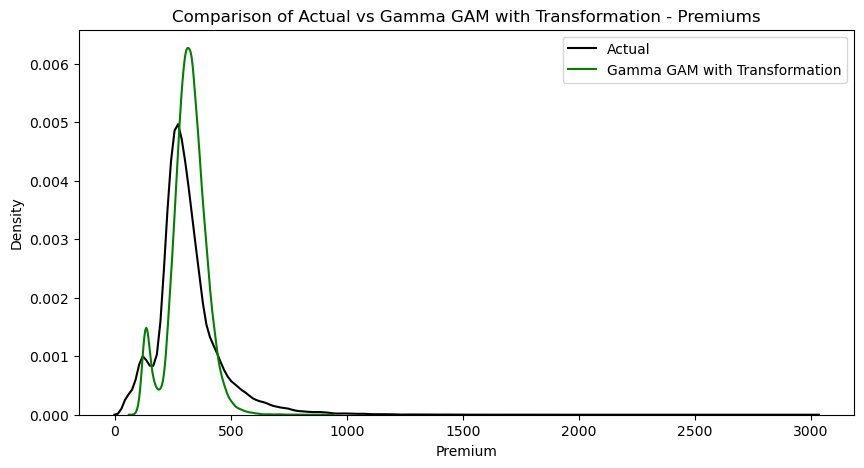

In [319]:
# Plot actual vs. predicted premiums
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['gam_gamma_trans_all'], label="Gamma GAM with Transformation", color='green')

plt.legend()
plt.title("Comparison of Actual vs Gamma GAM with Transformation - Premiums")
plt.show()

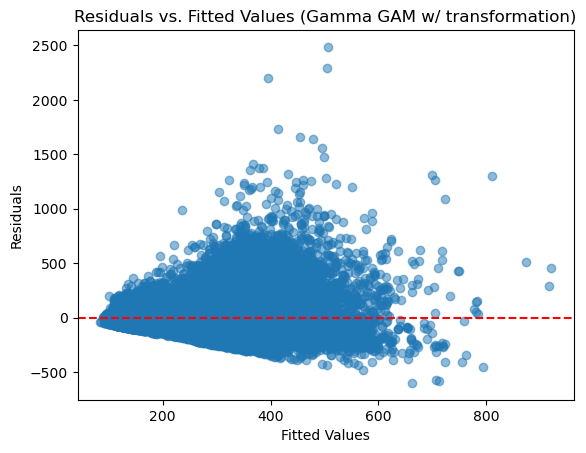

In [271]:
plt.scatter(
    gam_gamma_result_trans_all.fittedvalues, 
    gam_gamma_result_trans_all.resid_response, 
    alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values (Gamma GAM w/ transformation)")
plt.show()

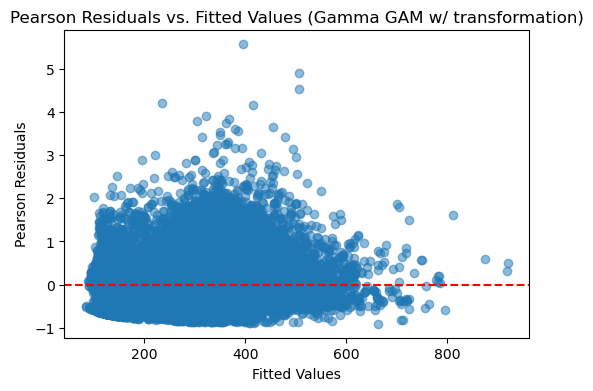

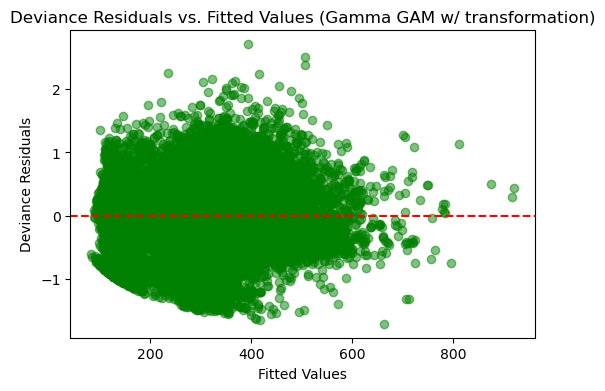

In [270]:
# 3. Extract fitted values and desired residuals
fitted_vals = gam_gamma_result_trans_all.fittedvalues

# Using Pearson residuals:
pearson_resids = gam_gamma_result_trans_all.resid_pearson
# Using deviance residuals:
deviance_resids = gam_gamma_result_trans_all.resid_deviance

# 4. Plot Pearson Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, pearson_resids, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.title("Pearson Residuals vs. Fitted Values (Gamma GAM w/ transformation)")
plt.show()

# 5. (Optional) Plot Deviance Residuals vs. Fitted Values
plt.figure(figsize=(6,4))
plt.scatter(fitted_vals, deviance_resids, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")
plt.title("Deviance Residuals vs. Fitted Values (Gamma GAM w/ transformation)")
plt.show()

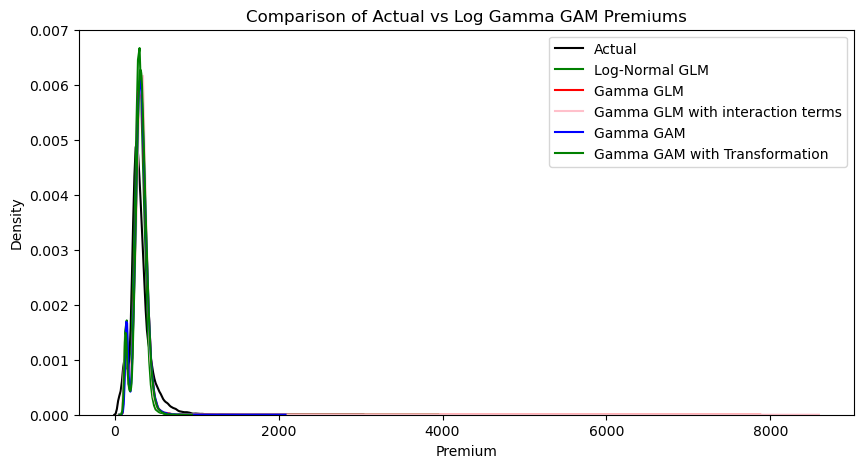

In [268]:
# Plot all models
plt.figure(figsize=(10,5))

sns.kdeplot(y, label="Actual", color='black')
sns.kdeplot(df_pred['glm-ln-no_trans-all'], label="Log-Normal GLM", color='green')
sns.kdeplot(df_pred['glm-gamma-no_trans-all'], label="Gamma GLM", color='red')
sns.kdeplot(df_pred['glm_gamma_inter_result_sig'], label="Gamma GLM with interaction terms", color='pink')
sns.kdeplot(df_pred['gam_gamma_all'], label="Gamma GAM", color='blue')
sns.kdeplot(df_pred['gam_gamma_trans_all'], label="Gamma GAM with Transformation", color='green')

plt.legend()
plt.title("Comparison of Actual vs Log Gamma GAM Premiums")
plt.show()